# Section 1 - Background & Literature Reviews

# Section 2 - Experiments

## 2.1 Training Models and Saving Results

Install and import the required packages

In [8]:
# pip tensorflow-determinism
# pip install numpy
# pip install opencv-python
# pip install scikit-learn
# pip install keras
# pip install tensorflow
# pip install matplotlib
# pip install pandas
from glob import glob # For reading data
import os
import random
import numpy as np # For storing large data in NP Arrays
import time
import cv2 # For image processing
import sklearn # For machine learning
import tensorflow as tf # For CNN
from tensorflow import keras # For CNN
import matplotlib.pyplot as plt # For data visualizing
from sklearn.model_selection import train_test_split # For splitting data into training set and testing set
from tensorflow.keras.models import Sequential # For NN
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization # For adding CNN convolution layers
from tensorflow.keras.optimizers import Adam # For Learning Rate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping # For saving model and stop training model earlier if needed
from tensorflow.keras.applications import ResNet50 # For using ResNet-50 Model

Note: The data folder is placed in the parent directory

In [9]:
# Function of loading photos as the data
def getData():
    real = glob("../data/original/*")
    fake_all = glob("../data/manipulated/*")
    trainX = []
    trainY = np.hstack((np.ones(len(real), dtype=int),np.zeros(len(fake_all),dtype=int)))
    l = len(real+fake_all)
    for img_path in (real+fake_all):
        trainX.append(np.array(cv2.resize(cv2.imread(img_path),(150,150))) / 255.0)
        if(len(trainX)%(0.1*l)==0):print(f'process: {100*len(trainX)/l}%**')
    return np.asarray(trainX), trainY

# Function of generating graph for CNN performance evaluations
def plotPerformance(hist,model,do,lr,bs):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history['val_accuracy'])
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
    plt.savefig(f'pics/{model}_{do}do{lr}lr{bs}bs.png')
    plt.show()

By mixing the real and manipulated photos we have total 12000 photos. First divide the training and test set.

In [ ]:
all_X,all_Y = getData()
trainX, testX, trainY, testY = train_test_split(all_X,all_Y,test_size=0.2, random_state=4487)
print(trainX.shape)
print(trainY.shape)

# CNN Model

In [ ]:
# Setting seed for constructing the same (or at least similar) model
os.environ['TF_CUDNN_DETERMINISTIC']= '1'
os.environ['PYTHONHASHSEED']= '4487'
np.random.seed(4487)
random.seed(4487)
tf.random.set_seed(4487)

print('Initialising configs...')

# do = input('Please enter the dropout rate: ')
# lr = input('Please enter the learning rate: ')
# epoch = input('Please enter the # of epochs: ')
# bs = input('Please enter the # of batch size: ')
do=0.2
lr=3e-2
epoch=50
bs=64
print('working on CNN model')
model = Sequential()

# First convolutional layer (7x7 kernel)
model.add(Conv2D(32, 7, activation='relu', padding='same', input_shape=(150,150,3)))
model.add(BatchNormalization()) # Normalizing input (mean close to 0 & S. close to 1)

# Second convolutional layer (5x5 kernel)
model.add(Conv2D(32, 5, activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())

# Third convolutional layer (3x3 kernel)
model.add(Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())

# Forth convolutional layer (3x3 kernel)
model.add(Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())

# Fifth convolutional layer (3x3 kernel)
model.add(Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())

model.add(MaxPooling2D()) # Downsample the input
model.add(Flatten()) # Flatten the input

# Output
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(float(do))) # For preventing overfitting
model.add(Dense(1, activation='sigmoid'))

# Compiling the model using binary_crossentropy loss function and evalutate accuracy score
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=float(lr)), metrics=['accuracy'])

# Early stop the program if the val_loss does not improve for 5 epochs
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 0, mode = 'min', restore_best_weights=True)

# Saving the best model according to val_accuracy (accuracy of testing)
checkpoint = ModelCheckpoint("ConvNet.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

In [ ]:
# Fitting the model
tf.random.set_seed(4487)
CNN_hist=model.fit(trainX,trainY,epochs=int(epoch),batch_size=int(bs),validation_data=(testX,testY), callbacks=[checkpoint, early_stopping])

# Plot the graph and save the performance
plotPerformance(CNN_hist,model,str(do),str(lr),str(bs))

# For the model outputs, some checkpoints were saved when they have obtained the best performance at that moment. We have vectorized the checkpoints and save as copies for later visualisations.
t = np.reshape(np.hstack((np.array(CNN_hist.history['accuracy']),np.array(CNN_hist.history['val_accuracy']),np.array(CNN_hist.history['loss']),np.array(CNN_hist.history['val_loss']))),(len(CNN_hist.history['accuracy']),4),'F')
np.save(f"vectors/CNN_{do}do{lr}lr{bs}bs",t)

# Resnet model

In [ ]:
# Setting seed for constructing the same (or at least similar) model
os.environ['TF_CUDNN_DETERMINISTIC']= '1'
os.environ['PYTHONHASHSEED']= '4487'
np.random.seed(4487)
random.seed(4487)
tf.random.set_seed(4487)

print('Initialising configs...')
model = "RESNET"
# do = input('Please enter the dropout rate: ')
# lr = input('Please enter the learning rate: ')
# epoch = input('Please enter the # of epochs: ')
# bs = input('Please enter the # of batch size: ')
do=0.23
lr=3e-4
epoch=50
bs=64
ResNet_model = Sequential()

# Adding ResNet50 layer
ResNet_model.add(ResNet50(weights='imagenet', include_top=False, classes=2, input_shape=(150,150,3)))
ResNet_model.add(BatchNormalization()) # Normalizing input (mean close to 0 & standart deviation close to 1)

ResNet_model.add(MaxPooling2D()) # Downsample the input
ResNet_model.add(Flatten()) # Flatten the input

# Output
ResNet_model.add(Dense(128, activation='relu', kernel_initializer = 'he_uniform')) # output = activation(dot(input, kernel) + bias)
ResNet_model.add(Dropout(float(do))) # For preventing overfitting
ResNet_model.add(Dense(1, activation = 'sigmoid'))

# Compiling the model using binary_crossentropy loss function and evalutate accuracy score
ResNet_model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=float(lr)), metrics=['accuracy'])

# ResNet_model = load_model(filepath="ResNet.h5", compile=True)
# Early stop the program if the val_loss does not improve for 5 epochs
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 0, mode = 'min', restore_best_weights=True)

# Saving the best model according to val_accuracy (accuracy of testing)
checkpoint = ModelCheckpoint("ResNet.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

In [ ]:
# Fitting the model
tf.random.set_seed(4487)
ResNet_hist=ResNet_model.fit(trainX,trainY,epochs=int(epoch),batch_size = int(bs),validation_data=(testX,testY), callbacks=[checkpoint, early_stopping])

# Plot the graph and save the performance
plotPerformance(ResNet_hist,model,str(do),str(lr),str(bs))

# For the model outputs, some checkpoints were saved when they have obtained the best performance at that moment. We have vectorized the checkpoints and save as copies for later visualisations.
t = np.reshape(np.hstack((np.array(ResNet_hist.history['accuracy']),np.array(ResNet_hist.history['val_accuracy']),np.array(ResNet_hist.history['loss']),np.array(ResNet_hist.history['val_loss']))),(len(ResNet_hist.history['accuracy']),4),'F')
np.save(f"vectors/RESNET_{do}do{lr}lr{bs}bs",t)

## 2.2 Results

We have decided to dig into the effects of different parameters. For both CNN and ResNet model, the hyperparameters are as below

- Dropout Rate
- Learning Rate
- Patience of Early Stopping
- Batch Size


In [9]:
# Then we could load the saved checkpoints and visualise them.
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import os
print(f'We have saved {len(os.listdir("vectors/"))} data, {len(glob("vectors/CNN*"))} for CNN model and {len(glob("vectors/RESNET*"))} for ResNet model')
print(os.listdir('vectors/'))


We have saved 15 data, 7 for CNN model and 8 for ResNet model
['CNN_0.23do1e-4lr32bs.npy', 'CNN_0.23do1e-4lr64bs.npy', 'CNN_0.23do3e-3lr32bs.npy', 'CNN_0.23do3e-3lr64bs.npy', 'CNN_0.2do3e-2lr32bs.npy', 'CNN_0.2do3e-3lr32bs.npy', 'CNN_0.2do3e-3lr64bs.npy', 'RESNET_0.23do0.0003lr32bs.npy', 'RESNET_0.23do3e-3lr64bs.npy', 'RESNET_0.23do3e-4lr32bs.npy', 'RESNET_0.2do3e-3lr32bs.npy', 'RESNET_0.2do3e-3lr64bs.npy', 'RESNET_0.3do0.003lr32bs.npy', 'RESNET_0.3do3e-3lr32bs.npy', 'RESNET_0.3do3e-3lr64bs.npy']


_**Short Terms**_

do -> Dropout Rate

lr -> Learning Rate

bs -> Batch Size

### CNN Models performance

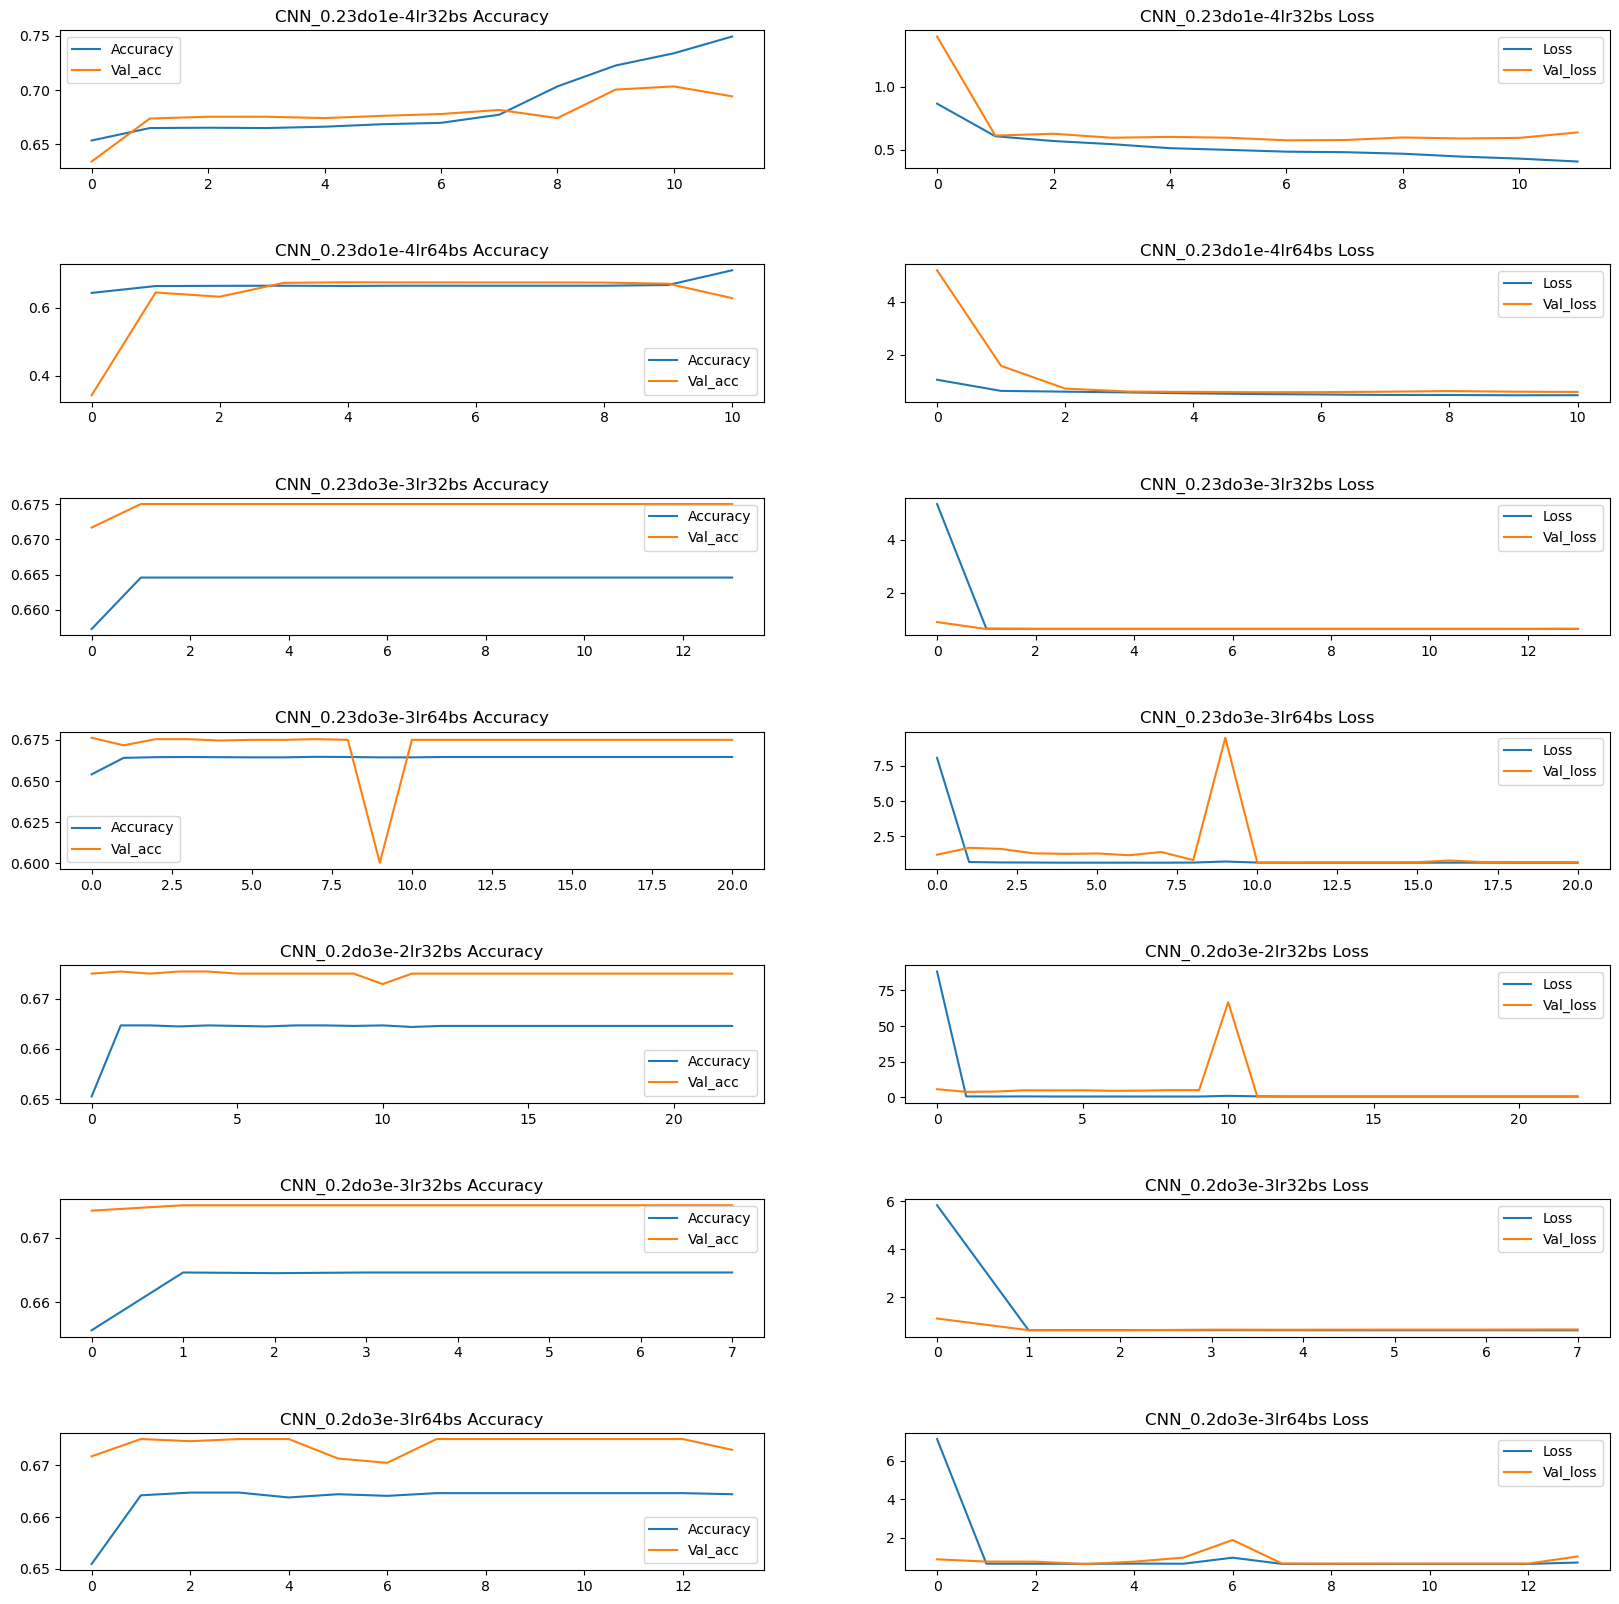

In [10]:
CNN = glob('vectors/CNN*')
rows = len(CNN)
fig,axs = plt.subplots(rows, 2,figsize=(20,20))
for row,data in enumerate(CNN):
    title = os.path.split(data[:-4])[1]
    d = np.load(data)
    axs[row,0].plot(d[:,0],label='Accuracy');axs[row,0].plot(d[:,1],label='Val_acc')
    axs[row,1].plot(d[:,2],label='Loss');axs[row,1].plot(d[:,3],label='Val_loss')
    axs[row,0].set_title(f'{title} Accuracy');axs[row,1].set_title(f'{title} Loss')
    axs[row,0].legend(loc='best');axs[row,1].legend(loc='best')
plt.subplots_adjust(hspace = 0.7)

We could notice that learning rate of 3e-3 has a more stable accuracy with fixed batch size

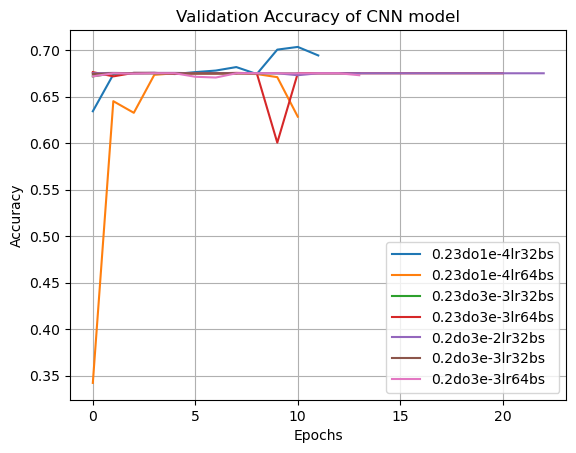

In [11]:
for data in CNN:
    config = data[data.find('_')+1:][:-4]
    d = np.load(data) # accuracy val_accuracy loss val_loss
    plt.plot(d[:,1], label=config)
plt.legend(loc='lower right')
plt.title('Validation Accuracy of CNN model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()

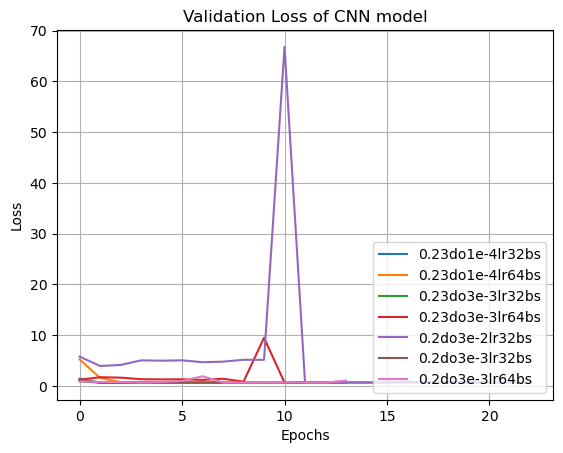

In [12]:
for data in CNN:
    config = data[data.find('_')+1:][:-4]
    d = np.load(data) # accuracy val_accuracy loss val_loss
    plt.plot(d[:,3], label=config)
plt.legend(loc='lower right')
plt.title('Validation Loss of CNN model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

123

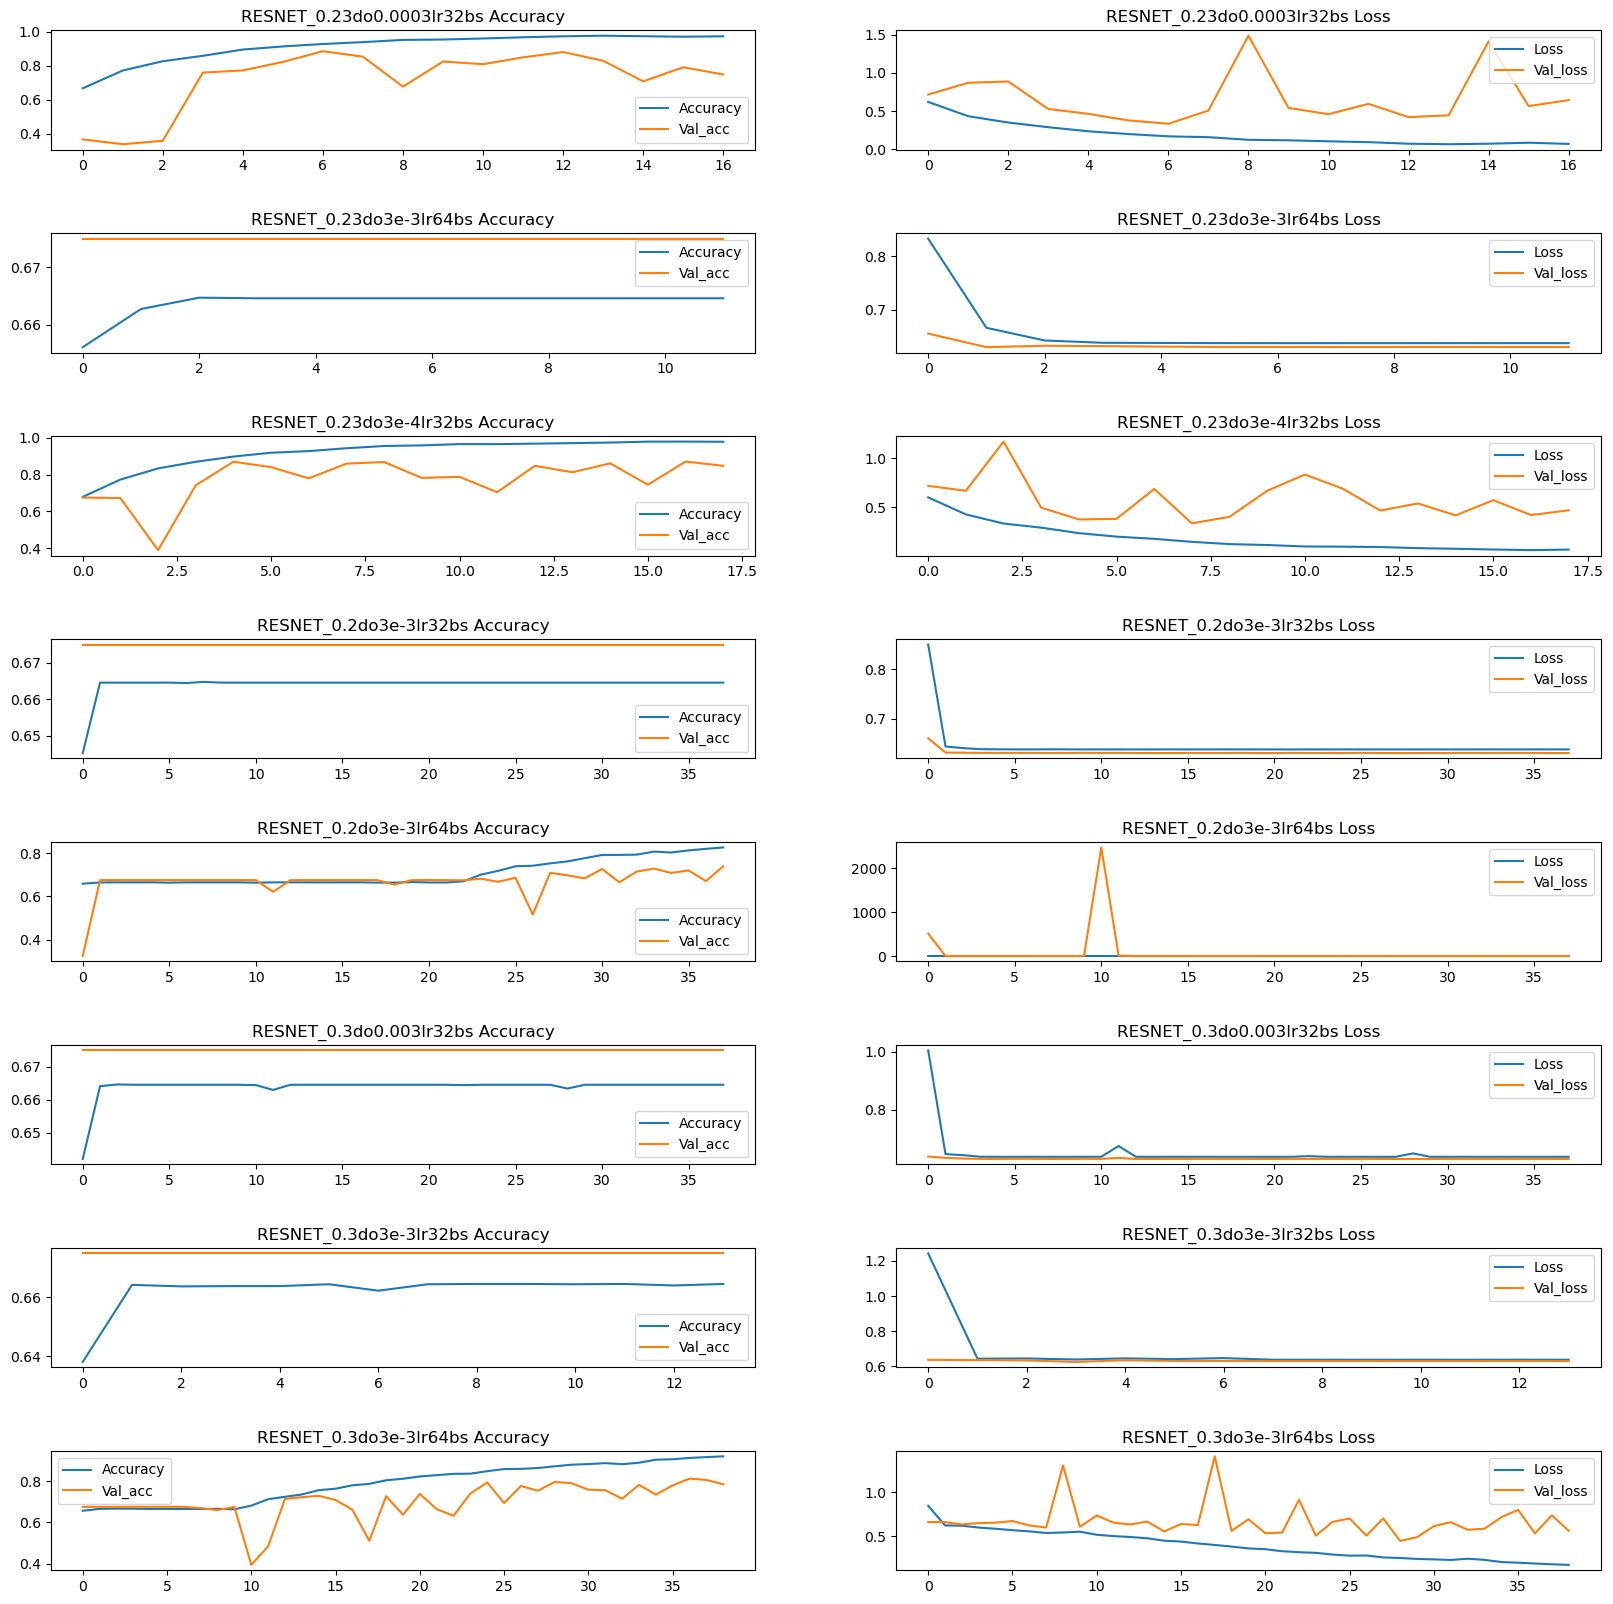

In [13]:
RESNET = glob('vectors/RESNET*')
rows = len(RESNET)
fig,axs = plt.subplots(rows, 2,figsize=(20,20))
for row,data in enumerate(RESNET):
    title = os.path.split(data[:-4])[1]
    d = np.load(data)
    axs[row,0].plot(d[:,0],label='Accuracy');axs[row,0].plot(d[:,1],label='Val_acc')
    axs[row,1].plot(d[:,2],label='Loss');axs[row,1].plot(d[:,3],label='Val_loss')
    axs[row,0].set_title(f'{title} Accuracy');axs[row,1].set_title(f'{title} Loss')
    axs[row,0].legend(loc='best');axs[row,1].legend(loc='best')
plt.subplots_adjust(hspace = 0.7)

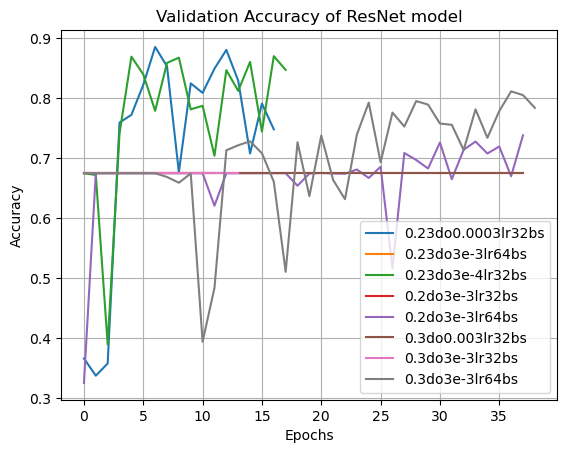

In [14]:
for data in RESNET:
    config = data[data.find('_')+1:][:-4]
    d = np.load(data) # accuracy val_accuracy loss val_loss
    plt.plot(d[:,1], label=config)
plt.legend(loc='lower right')
plt.title('Validation Accuracy of ResNet model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()

We could see that the lowest learning rate have the largest validation accuracy compared with a higher value in learning rate.

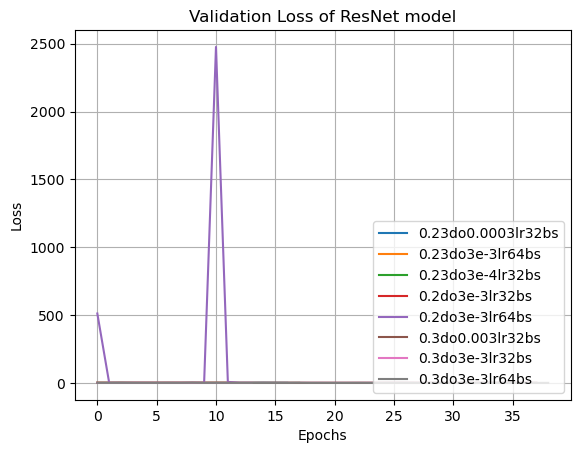

In [15]:
for data in RESNET:
    config = data[data.find('_') + 1:][:-4]
    d = np.load(data)  # accuracy val_accuracy loss val_loss
    plt.plot(d[:, 3], label=config)
plt.legend(loc='lower right')
plt.title('Validation Loss of ResNet model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

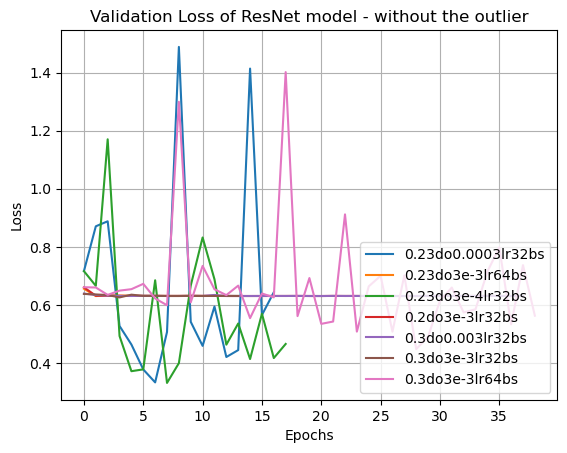

In [16]:
removed_outlier = RESNET.copy()
removed_outlier.remove('vectors/RESNET_0.2do3e-3lr64bs.npy')
for data in removed_outlier:
    config = data[data.find('_') + 1:][:-4]
    d = np.load(data)  # accuracy val_accuracy loss val_loss
    plt.plot(d[:, 3], label=config)
plt.legend(loc='lower right')
plt.title('Validation Loss of ResNet model - without the outlier')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

# Section 3 - Best Model

# Section 4 - Challenges

## Reproducing models with the same result

Since this project can only be handed in an ipynb file, we cannot upload the finished model directly. However, every time we run Keras, splitting the data set and the weighting inside the models differ. Thus, the result is inconsistent. As a result, we tried to figure out methods to reproduce the same or as similar as we could. We initially tried using the checkpoint callback to save and load the model. This function allows us to load the previously saved weights to re-evaluate or continue the existing model's training process. For instance, if the model stops training at epoch 5, we may load the same model and resume training again. For exmaple

- ### ResNet_model = load_model(filepath="ResNet.h5", compile=True)

However, we found that this method does not meet our goal since it still requires a model file to be loaded.

### Loading the same seeds
We then installed the package TensorFlow-determinism and make sure the seed of NumPy, python_random and TensorFlow were the same. Most of the time we gain same values for the val_accuracy and a little bit varies for the loss.

## GPU server

**packages conflict** During the package installation, since some versions of different packages are in conflict, it results in uninstallation of some sub-packages is required. Since TensorFlow is a large package in which some of its sub-packages are not compatible with the other packages in different versions. We wasted lots of time troubleshooting the package version problem even if the program can be run successfully on other devices or even on the same computer using CPU.

**Memory Limitations** It seems that there are limitations for memory usage every day for each account. In the beginning, we kept importing the full dataset for training models with different parameters and testing re-producing the same model until the out-of-memory error appeared. We then separate a small dataset with only 120 images (40 real, 80 fake) and reduce the number of epochs for testing.

<img src="Memory.jpeg" width="1600" height="372">
